In [1]:
import sxs
sxs.write_config(download=True, cache=True, auto_supersede=False)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import corner
import scipy

In [2]:
df = sxs.load("dataframe")

Loading SXS simulations using latest tag 'v3.0.0', published at 2025-05-14T18:17:30Z.


In [3]:
df_1 = df.loc[df['reference_eccentricity'] < 0.01]
df_2 = df_1.loc[df_1["reference_dimensionless_spin1_mag"] < 0.001]
df_4 = df_2.loc[df_2["reference_dimensionless_spin2_mag"] < 0.001]
df_5 = df_4.loc[df_4["deprecated"] == False]
df_3 = df_5.loc[np.isfinite(df_5["common_horizon_time"])]
#df_3 represents the low eccentricity and low spin simulations that will be relevant for my project
print(len(df_3))

81


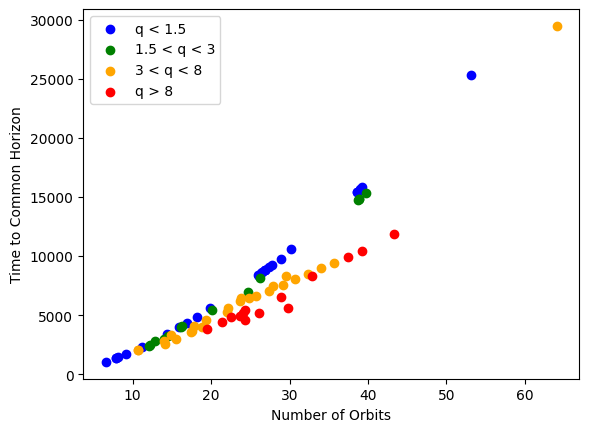

In [4]:
low_mass_ratio = np.full(len(df_3), r"SXS:BBH:0000")
med_low_mass_ratio = np.full(len(df_3), r"SXS:BBH:0000")
med_high_mass_ratio = np.full(len(df_3), r"SXS:BBH:0000")
high_mass_ratio = np.full(len(df_3), r"SXS:BBH:0000")

for i in range(len(df_3)):
    ind = df_3.index[i]
    if df_3["reference_mass_ratio"][ind] < 1.5:
        if ind[:8] != "SXS:NSNS":
            low_mass_ratio[i] = ind
    elif df_3["reference_mass_ratio"][ind] < 3:
        med_low_mass_ratio[i] = ind
    elif df_3["reference_mass_ratio"][ind] < 8:
        med_high_mass_ratio[i] = ind
    else:
        high_mass_ratio[i] = ind

low_mass_ratio = low_mass_ratio[low_mass_ratio != r"SXS:BBH:0000"]
med_low_mass_ratio = med_low_mass_ratio[med_low_mass_ratio != r"SXS:BBH:0000"]
med_high_mass_ratio = med_high_mass_ratio[med_high_mass_ratio != r"SXS:BBH:0000"]
high_mass_ratio = high_mass_ratio[high_mass_ratio != r"SXS:BBH:0000"]

plt.scatter(df_3["number_of_orbits_from_reference_time"][low_mass_ratio], df_3["common_horizon_time"][low_mass_ratio] - df_3["reference_time"][low_mass_ratio], color = "blue", label = "q < 1.5")
#plt.scatter(df_3.loc[low_mass_ratio, "number_of_orbits_from_reference_time"], df_3.loc[low_mass_ratio, "common_horizon_time"] - df_3.loc[low_mass_ratio, "reference_time"])
plt.scatter(df_3["number_of_orbits_from_reference_time"][med_low_mass_ratio], df_3["common_horizon_time"][med_low_mass_ratio] - df_3["reference_time"][med_low_mass_ratio], color = "green", label = "1.5 < q < 3")
plt.scatter(df_3["number_of_orbits_from_reference_time"][med_high_mass_ratio], df_3["common_horizon_time"][med_high_mass_ratio] - df_3["reference_time"][med_high_mass_ratio], color = "orange", label = "3 < q < 8")
plt.scatter(df_3["number_of_orbits_from_reference_time"][high_mass_ratio], df_3["common_horizon_time"][high_mass_ratio] - df_3["reference_time"][high_mass_ratio], color = "red", label = "q > 8")

plt.xlabel("Number of Orbits")
plt.ylabel("Time to Common Horizon")
plt.legend()
plt.savefig(r"C:\Users\Alex\OneDrive\Documents\Ohio_State_University\Penn_State_REU\num_orbits")

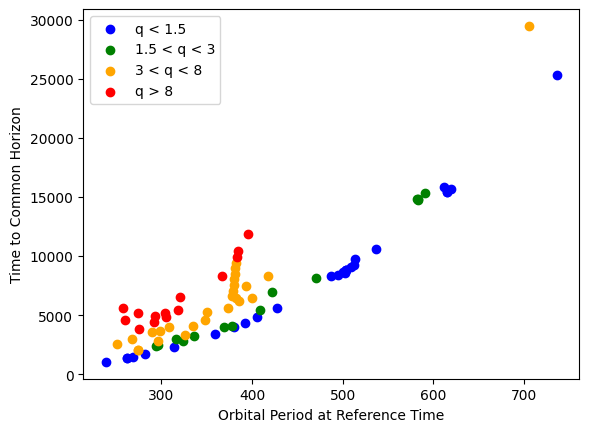

In [25]:
ref_orb_period_3 = 2*np.pi/df_3["reference_orbital_frequency_mag"]

plt.scatter(ref_orb_period_3[low_mass_ratio], df_3["common_horizon_time"][low_mass_ratio] - df_3["reference_time"][low_mass_ratio], color = "blue", label = "q < 1.5")
plt.scatter(ref_orb_period_3[med_low_mass_ratio], df_3["common_horizon_time"][med_low_mass_ratio] - df_3["reference_time"][med_low_mass_ratio], color = "green", label = "1.5 < q < 3")
plt.scatter(ref_orb_period_3[med_high_mass_ratio], df_3["common_horizon_time"][med_high_mass_ratio] - df_3["reference_time"][med_high_mass_ratio], color = "orange", label = "3 < q < 8")
plt.scatter(ref_orb_period_3[high_mass_ratio], df_3["common_horizon_time"][high_mass_ratio] - df_3["reference_time"][high_mass_ratio], color = "red", label = "q > 8")

plt.xlabel("Orbital Period at Reference Time")
plt.ylabel("Time to Common Horizon")
plt.legend()
plt.savefig(r"C:\Users\Alex\OneDrive\Documents\Ohio_State_University\Penn_State_REU\orb_period")

In [6]:
ref_com_hor_t_3 = df_3["common_horizon_time"] - df_3["reference_time"]

def scaling_CHT(tau, A):
    #tau is orbital period, q assumed to be 1, A is scaling constant
    #We are using this function to determine the scaling constant A for more general use determining the time of a common horizon forming
    return 4*A*tau**(8/3)

A_low = scipy.optimize.curve_fit(scaling_CHT, ref_orb_period_3[low_mass_ratio], ref_com_hor_t_3[low_mass_ratio])[0][0]

#def q_CHT(tau, q):
    ##tau is orbital period, q is mass ratio, A is scaling constant from previous function
    #return A*tau**(8/3)*(q+1)**2/q
#The above function doesn't work because the nonlinear, degenerate behavior of the function's dependence on q

A_medl = scipy.optimize.curve_fit(scaling_CHT, ref_orb_period_3[med_low_mass_ratio], ref_com_hor_t_3[med_low_mass_ratio])[0][0]
A_medh = scipy.optimize.curve_fit(scaling_CHT, ref_orb_period_3[med_high_mass_ratio], ref_com_hor_t_3[med_high_mass_ratio])[0][0]
A_high = scipy.optimize.curve_fit(scaling_CHT, ref_orb_period_3[high_mass_ratio], ref_com_hor_t_3[high_mass_ratio])[0][0]

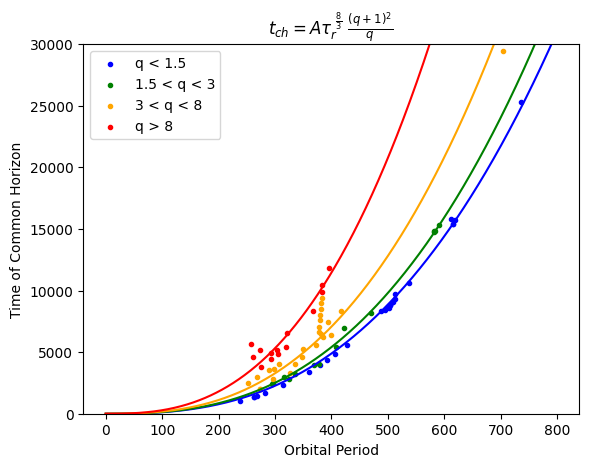

In [7]:
periods = np.arange(0,800)

plt.plot(periods, scaling_CHT(periods, A_low), color = "blue")
plt.scatter(ref_orb_period_3[low_mass_ratio], ref_com_hor_t_3[low_mass_ratio], color = "blue", marker = ".", label = "q < 1.5")

plt.plot(periods, scaling_CHT(periods, A_medl), color = "green")
plt.scatter(ref_orb_period_3[med_low_mass_ratio], ref_com_hor_t_3[med_low_mass_ratio], color = "green", marker = ".", label = "1.5 < q < 3")

plt.plot(periods, scaling_CHT(periods, A_medh), color = "orange")
plt.scatter(ref_orb_period_3[med_high_mass_ratio], ref_com_hor_t_3[med_high_mass_ratio], color = "orange", marker = ".", label = "3 < q < 8")

plt.plot(periods, scaling_CHT(periods, A_high), color = "red")
plt.scatter(ref_orb_period_3[high_mass_ratio], ref_com_hor_t_3[high_mass_ratio], color = "red", marker = ".", label = "q > 8")

ax = plt.gca()
ax.set_ylim([0,30000])
plt.xlabel("Orbital Period")
plt.ylabel("Time of Common Horizon")
plt.title(r"$t_{ch} = A\tau_{r}^{~\frac{8}{3}}~\frac{(q+1)^2}{q}$")
plt.legend()
plt.savefig(r"C:\Users\Alex\OneDrive\Documents\Ohio_State_University\Penn_State_REU\Modeling_CHT")

In [8]:

#This function will help us to visualize what the ratio of the constrained A for a mass_ratio group is to the constrained value for the lowest mass ratio group
def q_est(q):
    return (q+1)**2/(4*q)
    
print(f"A for lowest mass ratio group is {round(A_low, 6)}")
print(f"Is {round(A_low/A_low, 3)} < {round(q_est(1.5), 3)}?")
print(A_low/A_low <= q_est(1.5))
print()

print(f"A for medium low mass ratio group is {round(A_medl, 6)}")
print(f"Is {round(q_est(1.5), 3)} < {round(A_medl/A_low, 3)} < {round(q_est(3), 3)}?")
print(q_est(1.5) < A_medl/A_low and A_medl/A_low < q_est(3))
print()

print(f"A for medium high mass ratio group is {round(A_medh, 6)}")
print(f"Is {round(q_est(3), 3)} < {round(A_medh/A_low, 3)} < {round(q_est(8), 3)}?")
print(q_est(3) <= A_medh/A_low and A_medh/A_low <= q_est(8))
print()

print(f"A for high mass ratio group is {round(A_high, 6)}")
print(f"Is {round(q_est(8), 3)} < {round(A_high/A_low, 3)}?")
print(q_est(8) <= A_high/A_low)

if not q_est(8) <= A_high/A_low:
    print("I think this is false because A_low is actually skewed up higher than what it would be actually be for q = 1. That and we have least data for this mass ratio group, and the constant mass ratio assumption is the worst for this group since it has the largest spread in mass ratio.")

A for lowest mass ratio group is 0.000141
Is 1.0 < 1.042?
True

A for medium low mass ratio group is 0.000156
Is 1.042 < 1.106 < 1.333?
True

A for medium high mass ratio group is 0.000203
Is 1.333 < 1.445 < 2.531?
True

A for high mass ratio group is 0.00033
Is 2.531 < 2.343?
False
I think this is false because A_low is actually skewed up higher than what it would be actually be for q = 1. That and we have least data for this mass ratio group, and the constant mass ratio assumption is the worst for this group since it has the largest spread in mass ratio.


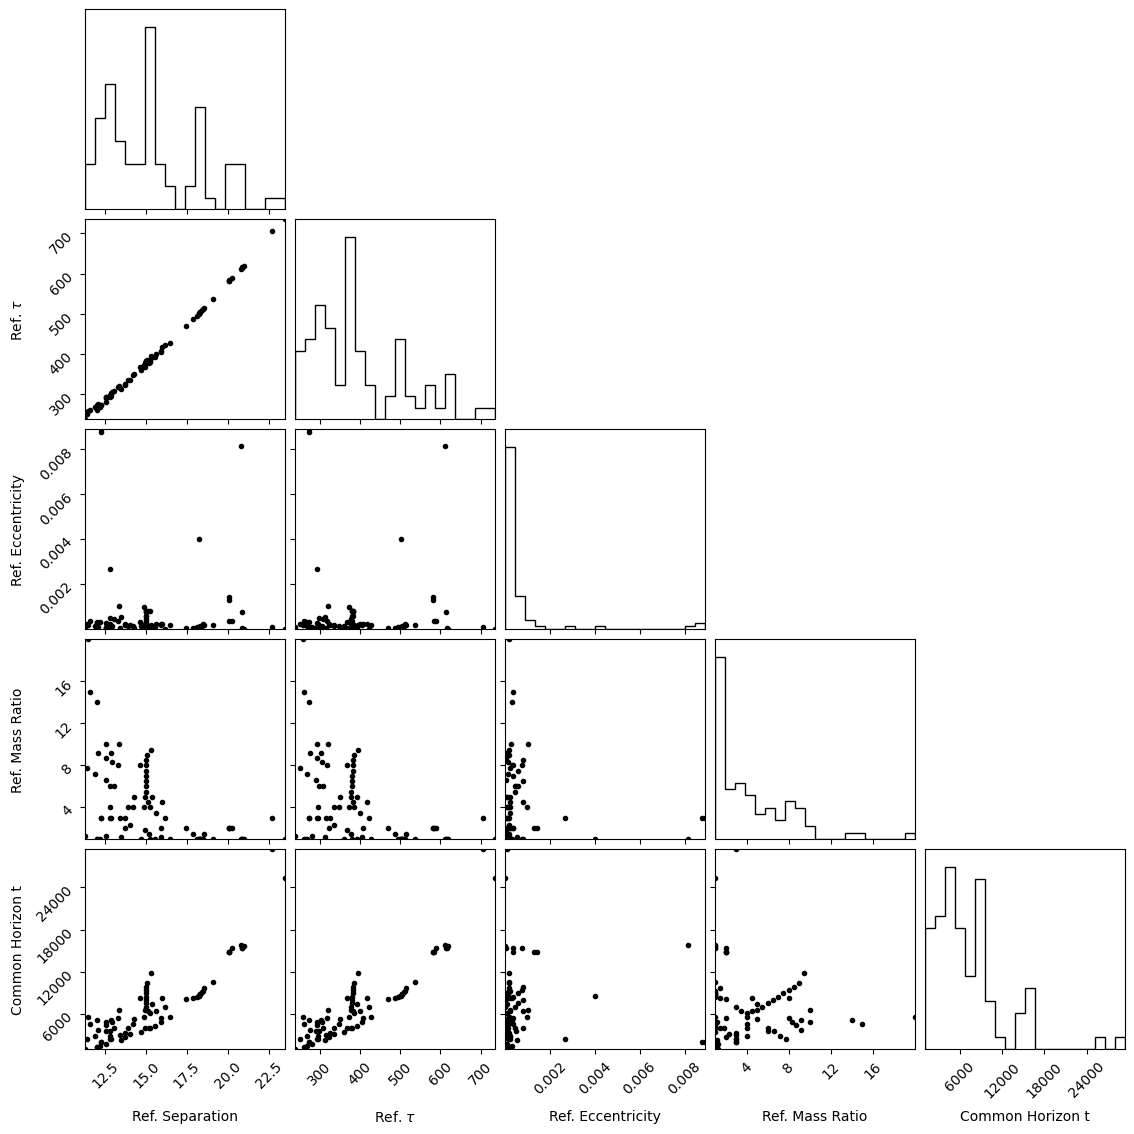

In [17]:
#To make a corner plot, I need to make a ndarray with as many entries as data sets that I want to plot]
num_param = 5
corner_array = np.column_stack([df_3["reference_separation"], ref_orb_period_3, df_3["reference_eccentricity"], df_3["reference_mass_ratio"], ref_com_hor_t_3])
#Here, we've stacked the columns because we want to plot points with data from the same event, but before we just had each value for all the events stored separately

corner_plot = corner.corner(
    corner_array,
    labels=[
        r"Ref. Separation",
        r"Ref. $\tau$",
        r"Ref. Eccentricity",
        r"Ref. Mass Ratio",
        r"Common Horizon t"],
    plot_contours = False, 
    plot_datapoints = True,
    plot_density = False,
    marker = ".",
    color = "black"
    #quantiles=[0.16, 0.5, 0.84],
    #show_titles=True,
    #title_kwargs={"fontsize": 12},
)
corner.overplot_points(corner_plot, corner_array, color = "black")

plt.savefig(r"C:\Users\Alex\OneDrive\Documents\Ohio_State_University\Penn_State_REU\corner_plot")

In [13]:
corner.overplot_points(corner_plot, corner_array)
plt.show()

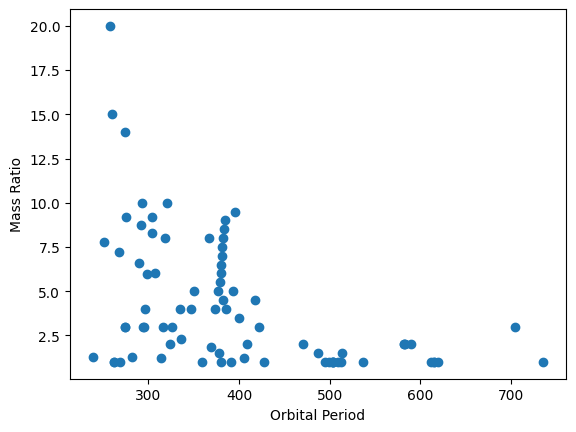

In [85]:
plt.scatter(ref_orb_period_3, df_3["reference_mass_ratio"])
plt.ylabel("Mass Ratio")
plt.xlabel("Orbital Period")
plt.savefig(r"C:\Users\Alex\OneDrive\Documents\Ohio_State_University\Penn_State_REU\mass_ratio_vs_period")

(200.0, 770.0)

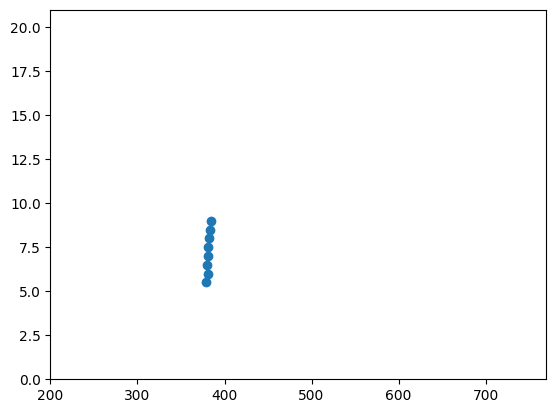

In [33]:
'''
for i in range(len(ref_orb_period_3)):
    if ref_orb_period_3[i] > 370 and ref_orb_period_3[i] < 390 and df_3.loc[df_3["reference_mass_ratio"] > 5] and 2*np.pi/df_3["reference_orbital_frequency_mag"] > 370 and 2*np.pi/df_3["reference_orbital_frequency_mag"] <390]:
        neat_orb_period.append(ref_orb_period_3[i])
'''      
#Note that I have to use the ampersand below because each condition is a series of boolean values. Python's "and" is only for single boolean values
#Note also that I need to put each condition into a set of parantheses to ensure that the operators are evaluated in the correct order
neat_orb_period = df_3.loc[(df_3["reference_mass_ratio"] > 5) & ((2*np.pi/df_3["reference_orbital_frequency_mag"]) > 370) & ((2*np.pi/df_3["reference_orbital_frequency_mag"]) <390)]
plt.scatter(2*np.pi/neat_orb_period["reference_orbital_frequency_mag"], neat_orb_period["reference_mass_ratio"])
ax = plt.gca()
ax.set_ylim([0,21])
ax.set_xlim([200, 770])

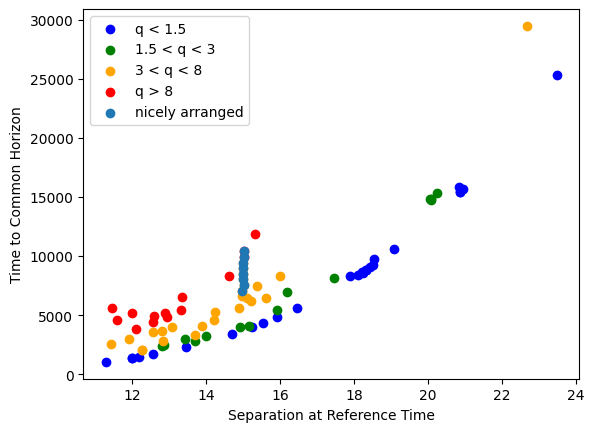

In [35]:
plt.scatter(df_3["reference_separation"][low_mass_ratio], df_3["common_horizon_time"][low_mass_ratio] - df_3["reference_time"][low_mass_ratio], color = "blue", label = "q < 1.5")
plt.scatter(df_3["reference_separation"][med_low_mass_ratio], df_3["common_horizon_time"][med_low_mass_ratio] - df_3["reference_time"][med_low_mass_ratio], color = "green", label = "1.5 < q < 3")
plt.scatter(df_3["reference_separation"][med_high_mass_ratio], df_3["common_horizon_time"][med_high_mass_ratio] - df_3["reference_time"][med_high_mass_ratio], color = "orange", label = "3 < q < 8")
plt.scatter(df_3["reference_separation"][high_mass_ratio], df_3["common_horizon_time"][high_mass_ratio] - df_3["reference_time"][high_mass_ratio], color = "red", label = "q > 8")
plt.scatter(neat_orb_period["reference_separation"], neat_orb_period["common_horizon_time"] - neat_orb_period["reference_time"], label = "nicely arranged")

plt.xlabel("Separation at Reference Time")
plt.ylabel("Time to Common Horizon")
plt.legend()
plt.savefig(r"C:\Users\Alex\OneDrive\Documents\Ohio_State_University\Penn_State_REU\separation_arranged")

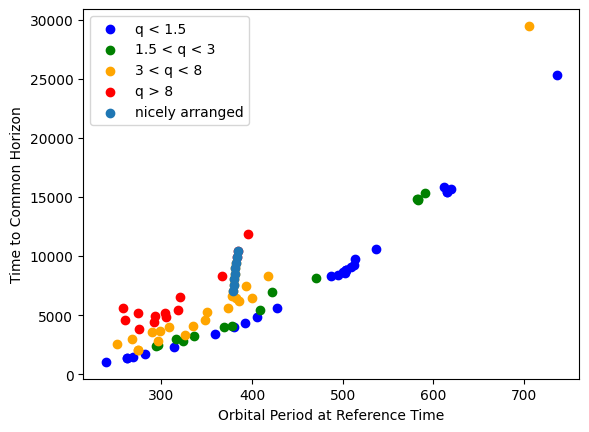

In [36]:
ref_orb_period_3 = 2*np.pi/df_3["reference_orbital_frequency_mag"]

plt.scatter(ref_orb_period_3[low_mass_ratio], df_3["common_horizon_time"][low_mass_ratio] - df_3["reference_time"][low_mass_ratio], color = "blue", label = "q < 1.5")
plt.scatter(ref_orb_period_3[med_low_mass_ratio], df_3["common_horizon_time"][med_low_mass_ratio] - df_3["reference_time"][med_low_mass_ratio], color = "green", label = "1.5 < q < 3")
plt.scatter(ref_orb_period_3[med_high_mass_ratio], df_3["common_horizon_time"][med_high_mass_ratio] - df_3["reference_time"][med_high_mass_ratio], color = "orange", label = "3 < q < 8")
plt.scatter(ref_orb_period_3[high_mass_ratio], df_3["common_horizon_time"][high_mass_ratio] - df_3["reference_time"][high_mass_ratio], color = "red", label = "q > 8")
plt.scatter(2*np.pi/neat_orb_period["reference_orbital_frequency_mag"], neat_orb_period["common_horizon_time"] - neat_orb_period["reference_time"], label = "nicely arranged")

plt.xlabel("Orbital Period at Reference Time")
plt.ylabel("Time to Common Horizon")
plt.legend()
plt.savefig(r"C:\Users\Alex\OneDrive\Documents\Ohio_State_University\Penn_State_REU\orb_period_arranged")

In [ ]:
from matplotlib import cm

plt.style.use('_mpl-gallery')

# Make data
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, Z, vmin=Z.min() * 2, cmap=cm.Blues)

ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])

plt.show()

In [88]:
def common_horizon_time(X, A, gam):
    #tau is orbital period, q is mass_ratio, A is scaling constant
    tau, q = X
    return A*tau**(gam)*(q+1)**2/q

ref_orb_period_3 = 2*np.pi/df_3["reference_orbital_frequency_mag"]
ref_com_hor_t_3 = df_3["common_horizon_time"] - df_3["reference_time"]

param = scipy.optimize.curve_fit(common_horizon_time, [ref_orb_period_3, df_3["reference_mass_ratio"]], ref_com_hor_t_3)
A, gam = param[0]

print(r"A is " + str(round(A, 8)) + r" ± " + str(round(np.sqrt(param[1][0][0]), 8)))

print(r"Gamma is " + str(round(gam, 3)) + r" ± " + str(round(np.sqrt(param[1][1][1]), 3)))


A is 2.434e-05 ± 1.98e-06
Gamma is 2.939 ± 0.013


In [74]:
def common_horizon_time_b(X, A, gam, b):
    #tau is orbital period, q is mass_ratio, A is scaling constant
    tau, q = X
    return A*tau**(gam)*(q+1)**b/q

ref_orb_period_3 = 2*np.pi/df_3["reference_orbital_frequency_mag"]
ref_com_hor_t_3 = df_3["common_horizon_time"] - df_3["reference_time"]

Ab, gamb, b = scipy.optimize.curve_fit(common_horizon_time_b, [ref_orb_period_3, df_3["reference_mass_ratio"]], ref_com_hor_t_3)[0]

print(Ab)
print(gamb)
print(b)

4.6420873200235384e-05
2.8478503141305587
1.9386756484786412


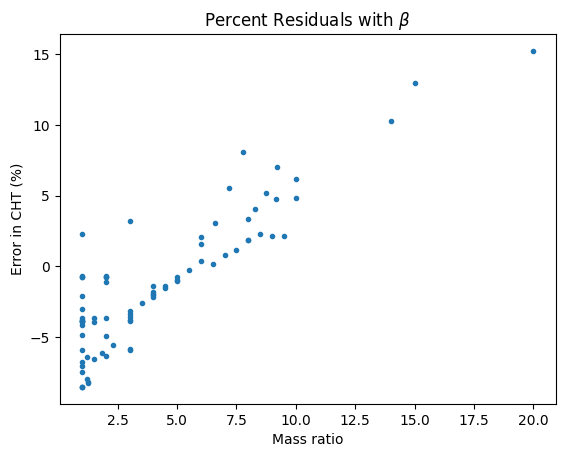

In [69]:
pred_com_hor_t_3_b = common_horizon_time_b([ref_orb_period_3, df_3["reference_mass_ratio"]], Ab, gamb, b)
 
plt.scatter(df_3["reference_mass_ratio"], ((pred_com_hor_t_3 - ref_com_hor_t_3)/ref_com_hor_t_3)*100, marker = ".")
plt.xlabel("Mass ratio")
plt.ylabel("Error in CHT (%)")
plt.title(r"Percent Residuals with $\beta$")
plt.savefig(r"C:\Users\Alex\OneDrive\Documents\Ohio_State_University\Penn_State_REU\Residuals_percent_b")

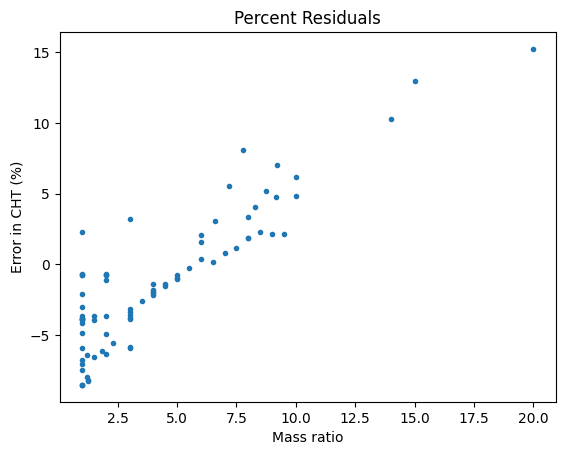

In [63]:
pred_com_hor_t_3 = common_horizon_time([ref_orb_period_3, df_3["reference_mass_ratio"]], A, gam)
 
plt.scatter(df_3["reference_mass_ratio"], ((pred_com_hor_t_3 - ref_com_hor_t_3)/ref_com_hor_t_3)*100, marker = ".")
plt.xlabel("Mass ratio")
plt.ylabel("Error in CHT (%)")
plt.title("Percent Residuals")
plt.savefig(r"C:\Users\Alex\OneDrive\Documents\Ohio_State_University\Penn_State_REU\Residuals_percent")

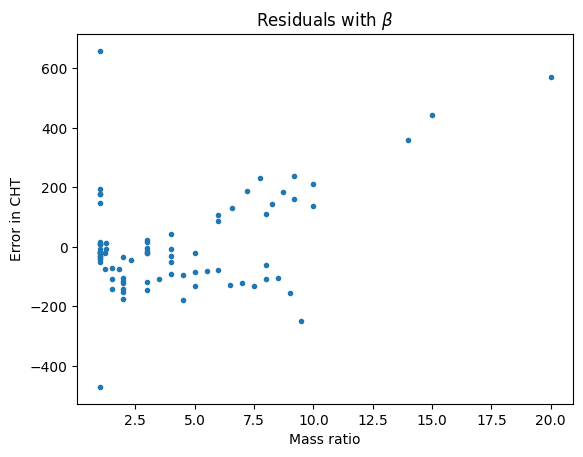

In [68]:
plt.scatter(df_3["reference_mass_ratio"], pred_com_hor_t_3_b - ref_com_hor_t_3, marker = ".")
plt.xlabel("Mass ratio")
plt.ylabel("Error in CHT")
plt.title(r"Residuals with $\beta$")
plt.savefig(r"C:\Users\Alex\OneDrive\Documents\Ohio_State_University\Penn_State_REU\Residuals_b")

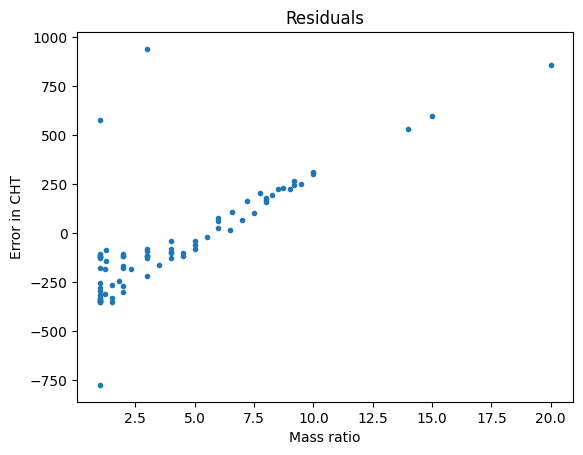

In [64]:
plt.scatter(df_3["reference_mass_ratio"], pred_com_hor_t_3 - ref_com_hor_t_3, marker = ".")
plt.xlabel("Mass ratio")
plt.ylabel("Error in CHT")
plt.title("Residuals")
plt.savefig(r"C:\Users\Alex\OneDrive\Documents\Ohio_State_University\Penn_State_REU\Residuals")

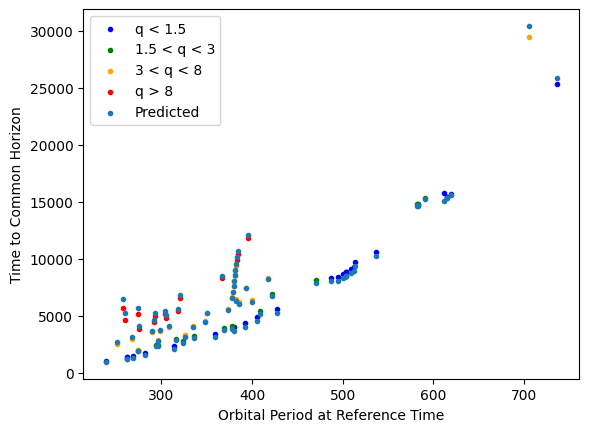

In [43]:
plt.scatter(ref_orb_period_3[low_mass_ratio], df_3["common_horizon_time"][low_mass_ratio] - df_3["reference_time"][low_mass_ratio], color = "blue", label = "q < 1.5", marker = ".")
plt.scatter(ref_orb_period_3[med_low_mass_ratio], df_3["common_horizon_time"][med_low_mass_ratio] - df_3["reference_time"][med_low_mass_ratio], color = "green", label = "1.5 < q < 3", marker = ".")
plt.scatter(ref_orb_period_3[med_high_mass_ratio], df_3["common_horizon_time"][med_high_mass_ratio] - df_3["reference_time"][med_high_mass_ratio], color = "orange", label = "3 < q < 8", marker = ".")
plt.scatter(ref_orb_period_3[high_mass_ratio], df_3["common_horizon_time"][high_mass_ratio] - df_3["reference_time"][high_mass_ratio], color = "red", label = "q > 8", marker = ".")
plt.scatter(ref_orb_period_3, pred_com_hor_t_3, label = "Predicted", marker = ".")

plt.xlabel("Orbital Period at Reference Time")
plt.ylabel("Time to Common Horizon")
plt.legend()
plt.savefig(r"C:\Users\Alex\OneDrive\Documents\Ohio_State_University\Penn_State_REU\Pred_Orb_Period")

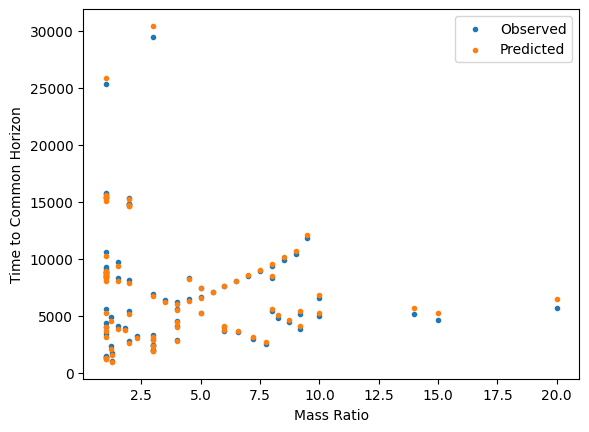

In [44]:
plt.scatter(df_3["reference_mass_ratio"], ref_com_hor_t_3, label = "Observed", marker = ".")
plt.scatter(df_3["reference_mass_ratio"], pred_com_hor_t_3, label = "Predicted", marker = ".")

plt.xlabel("Mass Ratio")
plt.ylabel("Time to Common Horizon")
plt.legend()
plt.savefig(r"C:\Users\Alex\OneDrive\Documents\Ohio_State_University\Penn_State_REU\Pred_Mass_Ratio")